# Bernoulli mixtures for mnist

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import log, exp

data=np.float64(np.load('/project/cmsc25025/mnist/MNIST.npy'))
labels=np.float32(np.load('/project/cmsc25025/mnist/MNIST_labels.npy'))

for i in data:
    i[np.nonzero(i)] = 1

In [2]:
def getDataRange(data, l, r):
    return data[int(l*len(data)):int(r*len(data))]

# This algorithm runs very slowly and thus I only ran it on 1000 data points. 
# Change the variable below to run it on more data points.
DATA_POINTS = 1000

demo_data = data[:DATA_POINTS]
demo_labels = labels[:DATA_POINTS]

train_data = getDataRange(demo_data, 0, 0.7)
valid_data = getDataRange(demo_data, 0.7, 0.85)
test_data = getDataRange(demo_data, 0.85, 1)

train_labels = getDataRange(demo_labels, 0, 0.7)
valid_labels = getDataRange(demo_labels, 0.7, 0.85)
test_labels = getDataRange(demo_labels, 0.85, 1)


In [3]:
def randomizeMixtures(X, y, M):
    mixtures = []
    for i in range(len(X)):
        mixtures.append(M * int(y[i]) + random.randint(0,M-1))
    return np.array(mixtures)

def getPi(X, mixtures, M):
    pi = np.zeros(M*10)
    for i in range(len(X)):
        pi[mixtures[i]] += 1
    pi = (pi+1)/(len(X)+2)
    return pi

def getP(X, mixtures, M):
    p = []
    d = len(X.T)
    n = len(X)
    ind = []
    for j in range(d):
        pj = np.zeros(10*M)
        p.append(pj)
    for m in range(10*M):
        indices = [i for i, x in enumerate(mixtures) if x == m]
        ind.append(len(indices))
        for i in indices:
            for j in range(d):
                p[j][m] += X[i][j]
        for j in range(d):
            p[j][m] = (p[j][m]+1)/(len(indices)+2)
    p = np.array(p)
    return p

def getL(xi, pim, pm):
    su = 0
    for j in range(len(xi)):
        su += xi[j]*log(pm[j]) + (1-xi[j])*log(1-pm[j])
    return su + log(pim)

def getW(X, p, pi, M):
    n = len(X)
    d = len(X.T)
    l = []
    for m in range(10*M):
        lm = []
        for i in range(n):
            lm.append(getL(X[i], pi[m], p.T[m]))
        l.append(lm)
    l = np.array(l)
    w = []
    for m in range(10*M):
        wm = []
        for i in range(n):
            L = max(l.T[i])
            sum_demon = sum([exp(lm - L) for lm in l.T[i]])
            wm.append((exp(l[m][i] - L))/sum_demon)
        w.append(wm)
    return np.array(w)

def eStep(X, mixtures, M):
    pi = getPi(X, mixtures, M)
    p = getP(X, mixtures, M)
    w = getW(X, p, pi, M)
    return p, pi, w


def mStep(X, p, pi, w, M):
    n = len(X)
    d = len(X.T)
    for m in range(10*M):
        sumw = 0
        for i in range(n):
            sumw += w[m][i]
        pi[m] = (sumw+1) / (n+2)
    
    for j in range(d):
        for m in range(10*M):
            sumw = 0
            sumwx = 0
            for i in range(n):
                sumw += w[m][i]
                sumwx += w[m][i] * X[i][j]
        p[j][m] = (sumwx+1)/(sumw+2)
    w = getW(X, p, pi, M)
    return p, pi, w

def logDenominator(X, p, pi, M):
    suml = 0
    n = len(X)
    for i in range(n):
        sumln = 0
        for m in range(10*M):
            sumln += exp(getL(X[i], pi[m], p.T[m]))
        suml += log(sumln)
    return suml
            
def mIterations(X, p, pi, w, M):
    l = logDenominator(test_data, p, pi, M)
    p, pi, w = mStep(X, p, pi, w, M)
    lnew = logDenominator(test_data, p, pi, M)
    while (lnew-l > 10):
        l = lnew
        p, pi, w = mStep(X, p, pi, w, M)
        lnew = logDenominator(test_data, p, pi, M)
    return p, pi, w

def em(X, Y, M):
    mixtures = randomizeMixtures(X, Y, M)
    p, pi, w = eStep(X, mixtures, M)
    if M>1:
        p, pi, w = mIterations(X, p, pi, w, M)
    return p, pi


In [4]:
p1, pi1 = em(train_data, train_labels, 1)
p3, pi3 = em(train_data, train_labels, 3)
p5, pi5 = em(train_data, train_labels, 5)

It is important to use $l_m(x)$ because if we don't than $f_m$ will always evaluate to 1 because it will take the exponent of an extremely small number. By using l, we eliminate this possibility as we wait until the end to take the exponent and thus, we take an exponent of a larger number, which will give us a real value.

(e) After you estimate the different components show the probability vectors you obtain as
an image, i.e. reshape p_j,m, j = 1, . . . , 282 as a 28 × 28 array. What do you see?

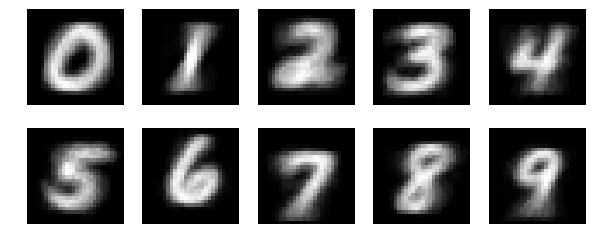

In [5]:
nrows = 2
ncols = 5
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(p1.T[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
plt.axis('off')
plt.show()

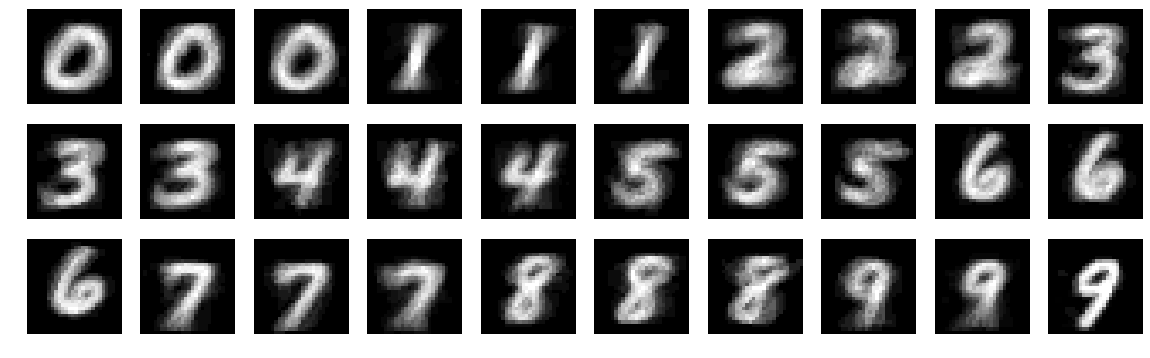

In [6]:
nrows = 3
ncols = 10
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(p3.T[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
plt.axis('off')
plt.show()

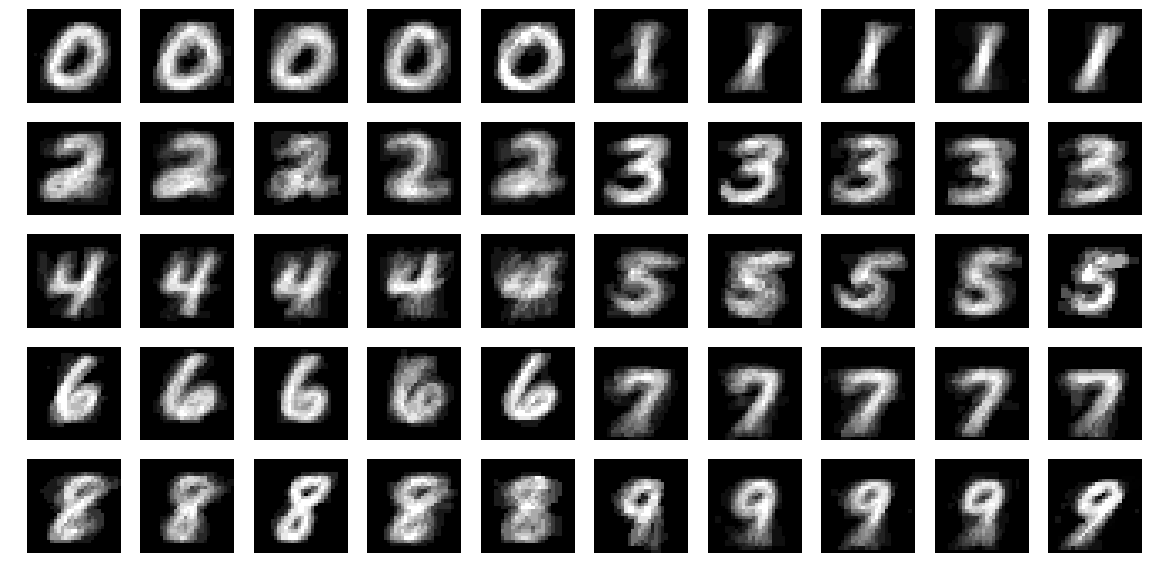

In [7]:
nrows = 5
ncols = 10
plt.figure(figsize=(ncols*2, nrows*2))
for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(p5.T[i].reshape((28,28)), cmap='gray')
    plt.axis('off')
plt.axis('off')
plt.show()

There is a clear distinction between the different models. When M = 1, each model represents a digit and when M > 1, then there are M models that represent each digit. When M = 3 or M = 5, you can see a slight variation in the numbers, which accounts for the difference in distribution of each model.

(f) Classify the test set data using Bayes’ rule with your estimated class mixture models and report your results for M=1,3,5.

In [8]:
def classify(x, p, pi, M):
    P = []
    d = len(x)
    for m in range(10*M):
        sumP = 0
        for j in range(d):
            sumP += x[j]*log(p[j][m]) + (1-x[j])*log(1-p[j][m])
        P.append(sumP)
    cm = max(enumerate(P), key = lambda x: x[1])[0]
    cmod = cm % M
    return (cm - cmod)/M

def massClassify(X, p, pi, M): 
    c = []
    for x in X:
        c.append(classify(x, p, pi, M))
    return c
    

In [9]:
c1 = massClassify(test_data, p1, pi1, 1)
c3 = massClassify(test_data, p3, pi3, 3)
c5 = massClassify(test_data, p5, pi5, 5)

error1 = np.mean(c1 != test_labels)
error3 = np.mean(c3 != test_labels)
error5 = np.mean(c5 != test_labels)

print("The error rate is with M = 1 is :", error1)
print("The error rate is with M = 3 is :", error3)
print("The error rate is with M = 5 is :", error5)

The error rate is with M = 1 is : 0.22666666666666666
The error rate is with M = 3 is : 0.22
The error rate is with M = 5 is : 0.18


In all 3 cases, the classifiers performed well and had consistent results. With only a 1000 data points, the classifiers were able to have an extremely low error rate. Interestingly, the classifiers with more models seemed to have slightly lower error rates, but because of the fact that we randomly put data points in each model, the error varies more with a higher M.